# Coffea-Casa Processor-Based Workflow Test

This notebook demonstrates the UnifiedProcessor workflow with coffea.processor.Runner on Coffea-Casa, including skimming, analysis, histogramming, and statistics steps.

## Workflow Overview

1. Setup Python path for intccms package
2. Install dependencies and register modules for cloud pickle
3. Acquire Dask client from Coffea-Casa environment
4. Configure analysis parameters
5. Run metadata extraction
6. Initialize UnifiedProcessor
7. Run processor with coffea.processor.Runner
8. Save histograms
9. Run statistical analysis (if enabled)

## AF flag
<span style="color:red">**(THIS NOTEBOOK ONLY SUPPORTED ON FACILITIES ALLOWING HTTPS PIP INSTALLS)**</span>.

<span style="color:red">*Works in coffacasa-condor*</span>.

We might want to run this code on different facilities, which may each have their own limitations or require different dask client setups. To make it easy to switch between facilities, just set the `AF` variable to the one of your choice. If your `AF` does not exist yet, you can introduce it in this notebook in the relevant sections.

In [1]:
AF="coffeacasa-condor" # options currently supported: [coffeacasa-condor, coffea-casa-gateway]

## Imports and dependencies

### The intccms package
The CMS implementation of the integration challenge is set in a package-like structure, which means we hae to add the source code to the python path. The package is referred to as `intccms`.

In [2]:
# Setup Python path to include intccms package
import sys
from pathlib import Path

# Add src directory to Python path
repo_root = Path.cwd()
src_dir = repo_root / "src"
examples_dir = repo_root
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))
if str(examples_dir) not in sys.path:
    sys.path.insert(0, str(examples_dir))
print(f"✅ Added {src_dir} to Python path")
print(f"✅ Added {examples_dir} to Python path")

✅ Added /home/cms-jovyan/intc/integration-challenge/cms/src to Python path
✅ Added /home/cms-jovyan/intc/integration-challenge/cms to Python path


### Installig extra dependencies
The `intccms` package requires `omegaconf`, which is not by default on an AF. 

In [3]:
try:
    import omegaconf
except ImportError:
    print("⚠️ omegaconf not found, installing...")
    ! pip install omegaconf

### Alternative coffea version
In some cases, we might need to install our own `coffea` version which is not on the AF. For example, when testing a new feature or using a recently realased version with a fix.

In [4]:
COFFEA_VERSION = "git+https://github.com/MoAly98/coffea.git@feat/fobj_in_procmeta" #"2025.11.0"
COFFEA_PIP = f"coffea=={COFFEA_VERSION}" if "git" not in COFFEA_VERSION else COFFEA_VERSION

if AF == "coffeacasa-gateway" and "git" in COFFEA_VERSION:
    raise ValueError("The coffea-casa dask gateway facility does not support installing packages with pip via https on workers.")

! pip install $COFFEA_PIP

  Cloning https://github.com/MoAly98/coffea.git (to revision feat/fobj_in_procmeta) to /tmp/pip-req-build-_fz5ci9j
  Running command git clone --filter=blob:none --quiet https://github.com/MoAly98/coffea.git /tmp/pip-req-build-_fz5ci9j
  Running command git checkout -b feat/fobj_in_procmeta --track origin/feat/fobj_in_procmeta
  Switched to a new branch 'feat/fobj_in_procmeta'
  branch 'feat/fobj_in_procmeta' set up to track 'origin/feat/fobj_in_procmeta'.
  Resolved https://github.com/MoAly98/coffea.git to commit 4fbf9086010c1986a98c0ab7bf91de6a2ce54d29
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Imports from stdlib and other libraries

In this notebook we use `dask` and `coffea`. 

In [5]:
# stdlib
import cloudpickle
from contextlib import contextmanager
import copy
import os
import time

from coffea.processor import DaskExecutor, IterativeExecutor
from coffea.nanoevents import NanoAODSchema
from dask.distributed import Client, PipInstall, WorkerPlugin

### Imports from intccms and other integration-challenge specific tooling

In [6]:
# for metrics collection
import roastcoffea # must be manually installed from source at the moment (pip install -e /path/to/repo/) from https://github.com/MoAly98/roastcoffea

# intccms
from intccms.schema import Config, load_config_with_restricted_cli
from intccms.utils.output import OutputDirectoryManager
from intccms.metadata_extractor import DatasetMetadataManager
from intccms.datasets import DatasetManager
from intccms.analysis import run_processor_workflow

### Registering packages with cloudpickle
The intccms cannot be installed on the workers via `pip`, and the configuration files are in python modules which also cannot be installed on the workers. So we need to register them with `cloudpickle` to allow dask to serialize them and send them out. `roastcoffea` is also currently not avialble on `pip` (wip). 

In [7]:
import intccms
import example_cms

# Register modules for cloud pickle
cloudpickle.register_pickle_by_value(intccms)
cloudpickle.register_pickle_by_value(example_cms)

## Dask client setup

This notebook uses the `DaskExecutor` from `coffea` to distribute the task graph on the AF. The client setup varies in different facilities, so we implement a function which returns the correct client. The function does so by providing a context manager, within which the client is alive.

In [8]:
@contextmanager
def acquire_client(af):
    """Context manager to acquire and safely close a Dask client from a Coffea-Casa environment."""

    # These are the pip-installable dependncies which should be installed on workers
    dependencies = [COFFEA_PIP, "git+https://github.com/MoAly98/roastcoffea.git"]
    client, cluster = None, None
    
    try:
        # Coffea-casa condor facility
        if af == "coffeacasa-condor":
            client = Client("tls://localhost:8786")
            client.register_plugin(PipInstall(packages=dependencies))
            client.forward_logging()

        # Coffea-casa dask gateway facility
        elif af == "coffea-casa-gateway":
            from dask_gateway import Gateway
        
            def set_env(dask_worker):
                config_path = str(Path(dask_worker.local_directory) / 'access_token')
                os.environ["BEARER_TOKEN_FILE"] = config_path
                os.chmod(config_path, 0o600)
                os.chmod("/etc/grid-security/certificates", 0o755)

            num_workers = 150   #number of workers desired
            gateway = Gateway()
            clusters = gateway.list_clusters()
            cluster = gateway.connect(clusters[0].name)
            client = cluster.get_client()
            cluster.scale(num_workers)
            client.wait_for_workers(num_workers)
            client.upload_file("/etc/cmsaf-secrets-chown/access_token")
            client.register_worker_callbacks(setup=set_env)
            client.register_plugin(PipInstall(packages=dependencies))

        print(f"✅ Connected to Dask scheduler")
        print(f"📊 Dashboard: {client.dashboard_link}")

        yield client, cluster
    
    except Exception as e:
        print(e)
    
    finally:
        if client is not None:
            client.close()
            print("✅ Client closed")

## Configuration Setup

The CMS analysis implementation is configurable via python modules, which we have to import. For this notebook, the configuration files are found in `example_cms/configs/`. You can modify the modules in this directory manually, or you can dynamically change settings using python dictionary manipulation. Below are some settings of interest that you might want to tune when you are testing your setup.

In [9]:
# intccms configuration import
from example_cms.configs.configuration import config as original_config

# Create a deepcopy that we can manipulate
config = copy.deepcopy(original_config)

# Limit files for testing
config["datasets"]["max_files"] = None # None would run over all availale files

# Use local output directory
config["general"]["output_dir"] = "example_cms/outputs/"

# Preprocessing (coffea) can be executed once and results loaded
# We recommend that on your second run of this notebook, set this to False to save time.
config["general"]["run_metadata_generation"] = True # If True, run analysis pre-processing

# Processer = Skimming (filter and save) + Analysis
config["general"]["run_processor"] = True  # If True, the coffea processor is executed
config["general"]["run_analysis"] = True # If True, the analysis part of the processor is executed
config["general"]["save_skimmed_output"] = False  # If True, skimmed events are saved to disk, otherwise filter executed on-the-fly

# Analysis = Systematics + histogramming + statsitics
config["general"]["run_histogramming"] = True
config["general"]["run_systematics"] = True
config["general"]["run_statistics"] = False

# Datasets to process, by default this is all datasets
#config["general"]["processes"] = ["data"] 

cli_args = [] # the code can be ran from CLI, but we don't care here
full_config = load_config_with_restricted_cli(config, cli_args)

# Validated config gives us a dictionary object with all settings checked to be safe with pydantic
validated_config = Config(**full_config)

## Running the Workflow

Running the CMS integration challenge workflow is split into a few steps, with a modular design that allows us flexibility. The steps are:

1. Setting up output directories
2. Building an input dataset manager
3. Running or loading the coffea preprocessing
4. Run the coffea processor

### Output manager setup

In [10]:
output_manager = OutputDirectoryManager(
    root_output_dir=validated_config.general.output_dir,
    cache_dir=validated_config.general.cache_dir,
    metadata_dir=validated_config.general.metadata_dir,
    skimmed_dir=validated_config.general.skimmed_dir
)

22:49:13 INFO     Output directory manager initialized with root:                                ]8;id=176074;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/directories.py\directories.py]8;;\:]8;id=36787;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/directories.py#169\169]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs                              

## Configure Data Redirector (Optional)

Override the redirector in the config for accessing dataset files. Useful for testing different storage backends. You can also change this in `example_cms/configs/skim.py`

In [11]:
# Override redirector for all datasets
# Examples:
#   "root://xcache/"                    
#   "root://cmsxrootd.fnal.gov/"
#   "root://cms-xrd-global.cern.ch/"
REDIRECTOR = "root://xcache/"  # Change this to use a different redirector

print(f"Initial redirector  {validated_config.datasets.datasets[0].name}: {validated_config.datasets.datasets[0].redirector}")

# Apply to all datasets in config
for dataset in validated_config.datasets.datasets:
 dataset.redirector = REDIRECTOR

print(f"Redirector set to: {REDIRECTOR}")

# Verify the change
print(f"New redirector:  {validated_config.datasets.datasets[0].name}: {validated_config.datasets.datasets[0].redirector}")

Initial redirector  signal: root://xcache/
Redirector set to: root://xcache/
New redirector:  signal: root://xcache/


### Input dataset manager setup

In [12]:
dataset_manager = DatasetManager(validated_config.datasets)

         INFO     Initialized dataset manager with 10 datasets                                        ]8;id=877282;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/datasets/manager.py\manager.py]8;;\:]8;id=115372;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/datasets/manager.py#34\34]8;;\

### Coffea preprocessing

In [13]:
metadata_generator = DatasetMetadataManager(
  dataset_manager=dataset_manager,
  output_manager=output_manager,
  config=validated_config,
)

if metadata_generator.generate_metadata:
  with acquire_client(AF) as (client, cluster):
      metadata_generator.run(executor=DaskExecutor(client))
else:
  metadata_generator.run()  # No client needed

# Build metadata lookup and extract workitems
metadata_lookup = metadata_generator.build_metadata_lookup()
workitems = metadata_generator.workitems
print(f"Generated {len(workitems)} workitems ...")

         INFO     Initialized DatasetMetadataManager with output dir:                                ]8;id=934682;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=872147;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#128\128]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/metadata                     

         INFO     Loading existing metadata from:                                                    ]8;id=710246;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=762465;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#236\236]8;;\
                  {                                                                                                
                      'fileset_path':                                                                              
                  PosixPath('/home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/met               
                  adata/fileset.json'),                                                                            
                      'workitems_path':                                                                            
                  PosixPath('/home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/met               
                  adata/workitems.json'),                                                                          
                      'nanoaods_summary_path':                                                                     
                  PosixPath('/home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/met               
                  adata/nanoaods.json')                                                                            
                  }                                                                                                

         INFO     Loaded 10 Dataset objects from fileset                                             ]8;id=738774;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=483341;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#341\341]8;;\

         INFO     Loaded 4348 WorkItems                                                              ]8;id=457228;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=920633;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#348\348]8;;\

         INFO     Loaded event count summary                                                         ]8;id=793828;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=112618;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#354\354]8;;\

         INFO     All metadata successfully loaded from disk.                                        ]8;id=472087;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=253373;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#244\244]8;;\

         INFO     Built metadata lookup for 125 fileset keys                                         ]8;id=592317;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py\manager.py]8;;\:]8;id=289874;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/metadata_extractor/manager.py#442\442]8;;\

Generated 4348 workitems ...


### Run the coffea processor!

In [14]:
# Run processor workflow with roastcoffea metrics collection
from roastcoffea import MetricsCollector
from intccms.analysis.processor import UnifiedProcessor

with acquire_client(AF) as (client, cluster):
    # Create processor instance for MetricsCollector
    unified_processor = UnifiedProcessor(
        config=validated_config,
        output_manager=output_manager,
        metadata_lookup=metadata_lookup,
    )

    # Wrap workflow in MetricsCollector for comprehensive metrics
    with MetricsCollector(
        client=client,
        processor_instance=unified_processor,
        track_workers=True,
        worker_tracking_interval=1.0,
    ) as collector:
        t0 = time.perf_counter()
        output, report = run_processor_workflow(
            config=validated_config,
            output_manager=output_manager,
            metadata_lookup=metadata_lookup,
            workitems=workitems,
            executor=DaskExecutor(client=client, treereduction=8, retries=0),
            schema=NanoAODSchema,
        )
        t1 = time.perf_counter()

        # Extract chunk metrics from output (injected by @track_metrics decorator)
        collector.extract_metrics_from_output(output)

        # Set coffea report for aggregation
        collector.set_coffea_report(report)

    # Get aggregated metrics after context exits
    metrics = collector.get_metrics()
    tracking_data = collector.tracking_data
    span_metrics = getattr(collector, 'span_metrics', None)

print(f"✅ Processor workflow complete in {t1-t0:.1f} seconds!")

# Print summary
print(f"Total events processed: {output.get('processed_events', 0):,}")
print(f"Events after skim: {output.get('skimmed_events', 0):,}")

✅ Connected to Dask scheduler
📊 Dashboard: /user/mohamed.aly@cern.ch/proxy/8787/status


22:51:41 INFO     Initialized UnifiedProcessor: save_skimmed_output=False, analysis=True,          ]8;id=293383;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=230765;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#195\195]8;;\
                  histogramming=True, systematics=True                                                             

         INFO     Running processor over data...                                                      ]8;id=264681;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=905049;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py#109\109]8;;\

         INFO     Initialized UnifiedProcessor: save_skimmed_output=False, analysis=True,          ]8;id=96138;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=959860;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#195\195]8;;\
                  histogramming=True, systematics=True                                                             

         INFO     Processing 4348 work items with chunksize=200000                                    ]8;id=797913;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=950582;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py#199\199]8;;\

Output()

22:53:35 INFO     Postprocessing complete: 794088713 total events                                  ]8;id=185513;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=136492;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#387\387]8;;\

         INFO     Histograms written to pickle:                                                    ]8;id=242783;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=930176;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py#45\45]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/p                 
                  rocessor_histograms.pkl                                                                          

         INFO     Saved processor histograms (pickle) to                                           ]8;id=600741;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=325687;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#399\399]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/p                 
                  rocessor_histograms.pkl                                                                          

         INFO     Filtered 8 invalid systematic variations from data samples                      ]8;id=767041;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=121737;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py#188\188]8;;\

         INFO     Histograms written to ROOT file:                                                ]8;id=818153;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py\histograms.py]8;;\:]8;id=498327;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/utils/output/histograms.py#137\137]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/                  
                  histograms.root                                                                                  

         INFO     Saved processor histograms (ROOT) to                                             ]8;id=920711;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py\processor.py]8;;\:]8;id=626573;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/processor.py#407\407]8;;\
                  /home/cms-jovyan/intc/integration-challenge/cms/example_cms/outputs/histograms/h                 
                  istograms.root                                                                                   

         INFO     Processor complete: 794,088,713 events processed, 30,703,728 events after skim      ]8;id=259974;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py\runner.py]8;;\:]8;id=835784;file:///home/cms-jovyan/intc/integration-challenge/cms/src/intccms/analysis/runner.py#205\205]8;;\

✅ Client closed
✅ Processor workflow complete in 114.2 seconds!
Total events processed: 794,088,713
Events after skim: 30,703,728


## Performance Metrics (roastcoffea)

This section displays comprehensive performance metrics collected during the workflow execution using `roastcoffea`.

### Summary tables

`roastcoffea` provides useful summary tables, formatted using `rich` and ready to be printed in a `rich` console. 

In [15]:
# Import roastcoffea reporting and visualization
from rich.console import Console
from roastcoffea.export.reporter import (
    format_throughput_table,
    format_event_processing_table,
    format_resources_table,
    format_timing_table,
    format_fine_metrics_table,
)

console = Console()

print("\n📈 Throughput Metrics")
console.print(format_throughput_table(metrics))

print("\n⚡ Event Processing Metrics")
console.print(format_event_processing_table(metrics))

print("\n🖥️  Resource Utilization")
console.print(format_resources_table(metrics))

print("\n⏱️  Timing Breakdown")
console.print(format_timing_table(metrics))

# Fine-grained metrics from Dask Spans (CPU/IO breakdown)
print("\n🔬 Fine-Grained Metrics (CPU/IO Breakdown)")
console.print(format_fine_metrics_table(metrics))



📈 Throughput Metrics


                  Throughput Metrics                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric                    ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Data Rate                 │ 4.84 Gbps (605.3 MB/s) │
│ Total Bytes Read (Coffea) │ 64.41 GB               │
│ Memory Read (Dask Spans)  │ 1.29 GB                │
└───────────────────────────┴────────────────────────┘


⚡ Event Processing Metrics


           Event Processing Metrics           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                     ┃ Value         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Total Events               │ 794,088,713   │
│ Event Rate (Elapsed Time)  │ 6950.7 kHz    │
│ Event Rate (Total CPU)     │ 49.7 kHz      │
│ Event Rate (Core-Averaged) │ 23.2 kHz/core │
│ Efficiency Ratio           │ 13978.4%      │
└────────────────────────────┴───────────────┘


🖥️  Resource Utilization


          Resource Utilization          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                   ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Workers (Time-Averaged)  │ 300.0     │
│ Peak Workers             │ 300       │
│ Cores per Worker         │ 1.0       │
│ Total Cores              │ 300       │
│ Core Efficiency          │ 46.6%     │
│ Speedup Factor           │ 139.8x    │
│ Peak Memory (per worker) │ 876.18 MB │
│ Avg Memory (per worker)  │ 723.78 MB │
└──────────────────────────┴───────────┘


⏱️  Timing Breakdown


         Timing Breakdown         
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric             ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Elapsed Time       │ 1m 54s    │
│ Total CPU Time     │ 4h 26m 9s │
│ Number of Chunks   │ 4,348     │
│ Avg CPU Time/Chunk │ 3.7s      │
└────────────────────┴───────────┘


🔬 Fine-Grained Metrics (CPU/IO Breakdown)


        Fine Metrics (from Dask Spans)         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Metric                           ┃ Value    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Processor CPU Time               │ 8h 0m 9s │
│ Processor I/O & Waiting Time     │ 47m 38s  │
│   CPU %                          │ 91.0%    │
│   I/O & Wait %                   │ 9.0%     │
│ Dask Overhead CPU Time           │ 4.3s     │
│ Dask Overhead I/O & Waiting Time │ 1.2s     │
└──────────────────────────────────┴──────────┘

### Performance Visualizations

`roastcoffea` provides API for useful plots that demonstrate various aspects of the processing. 

### Imports

In [16]:
import matplotlib.pyplot as plt
from roastcoffea.visualization.plots import (
  plot_worker_count_timeline,
  plot_memory_utilization_mean_timeline,
  plot_memory_utilization_per_worker_timeline,
  plot_cpu_utilization_mean_timeline,
  plot_cpu_utilization_per_worker_timeline,
  plot_throughput_timeline,
  plot_per_task_cpu_io,
  plot_compression_ratio_distribution,
  plot_data_access_percentage,
  plot_runtime_distribution,
  plot_runtime_vs_events,
)

#### Timeline plots
These are plots that offer a temporal view of the processing.


Worker Count Over Time


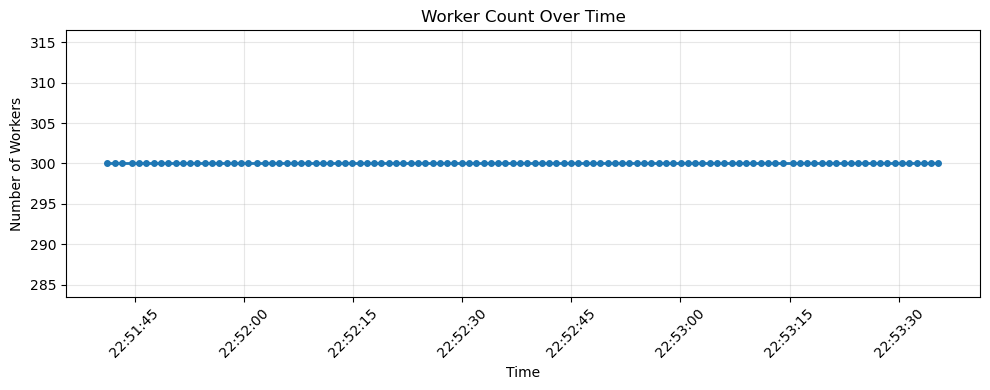


📊 Data Throughput Over Time


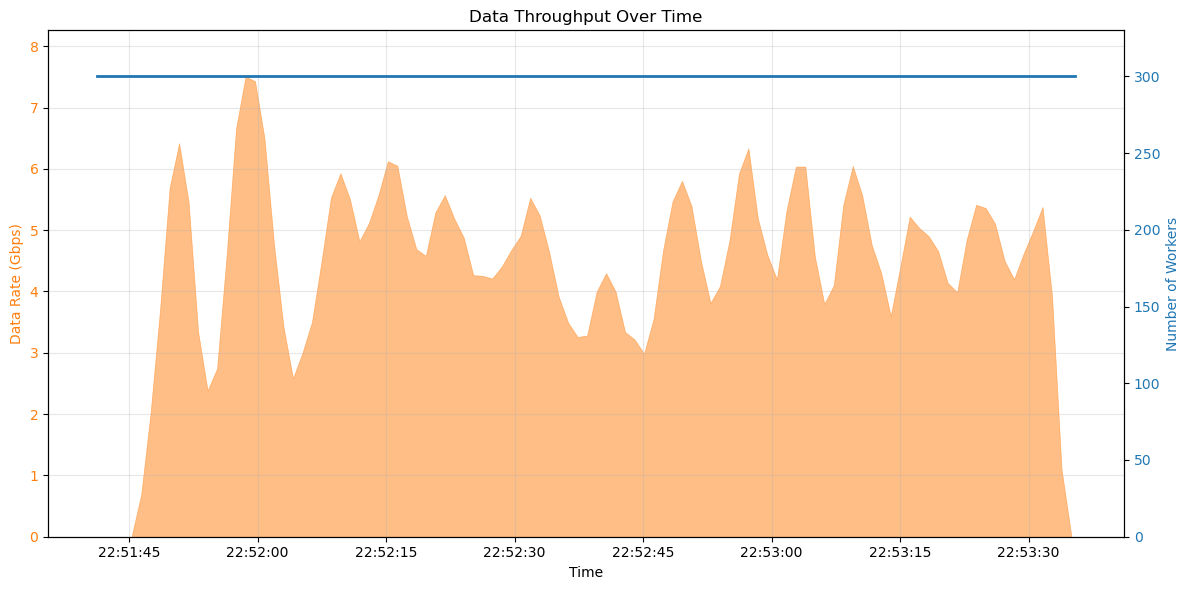


 Memory Utilization (mean)


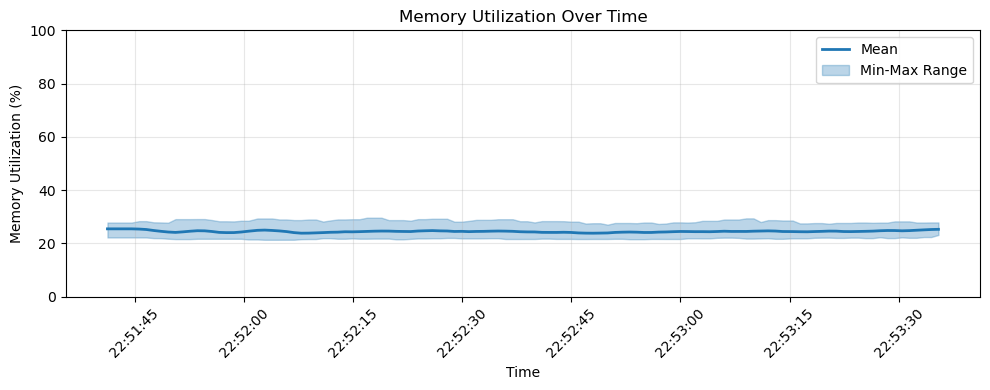


 Memory Utilization (per worker)


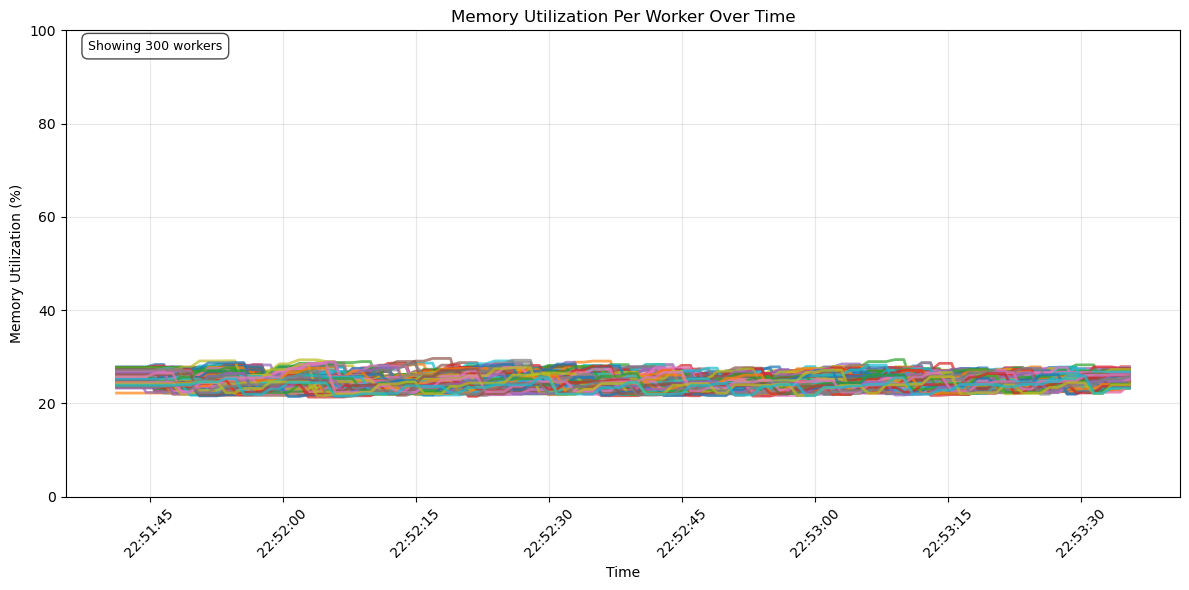


 CPU Utilization (mean)


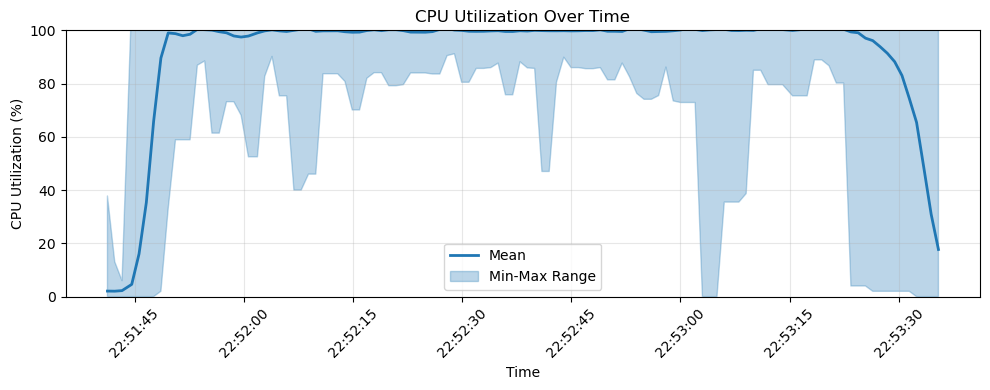


 CPU Utilization (per worker)


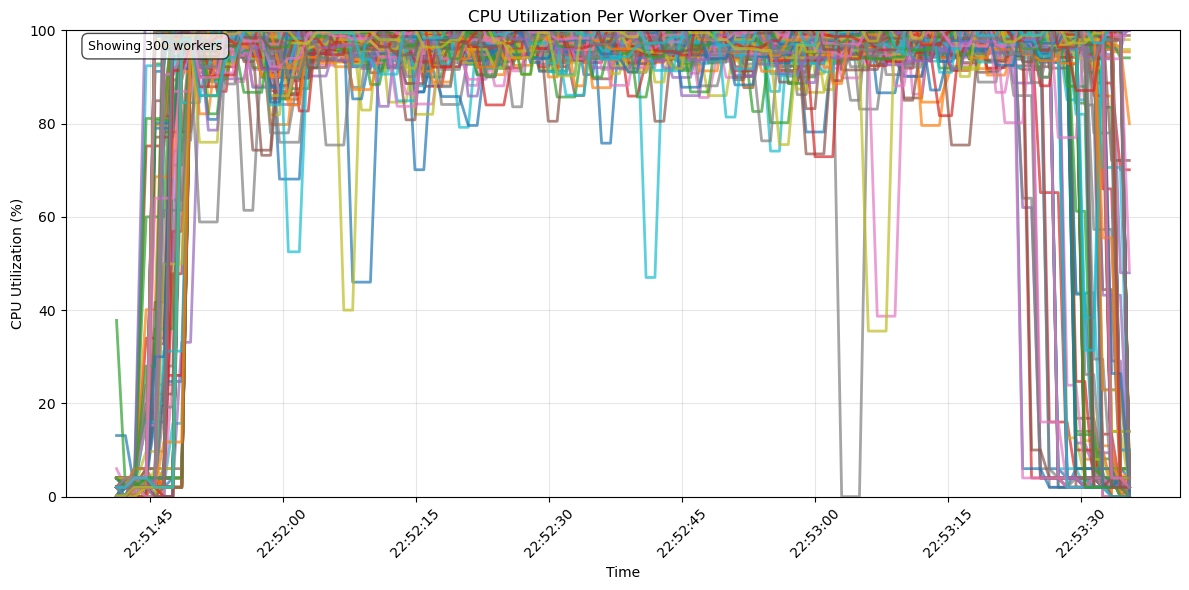

In [17]:
# ========================================================================
# Worker Count Over Time
# This shows how many workers were active as the processor was running
# ========================================================================
print("\nWorker Count Over Time")
try:
  fig, ax = plot_worker_count_timeline(tracking_data)
  plt.show()
except Exception as e:
  print(f"⚠️  Worker count plot unavailable: {e}")

# ========================================================================
# Data throughput over time
# This shows the rate at which data was being processed over time
# ========================================================================
print("\n📊 Data Throughput Over Time")
try:
  fig, ax = plot_throughput_timeline(metrics["chunk_info"], tracking_data)
  plt.show()
except Exception as e:
  print(f"⚠️  Throughput plot unavailable: {e}")


# ========================================================================
# Memory utilisation over time
# This shows the percentage of memory being utilised per worker and on average from all workers 
# ========================================================================
print("\n Memory Utilization (mean)")
try:
  fig, ax = plot_memory_utilization_mean_timeline(tracking_data)
  plt.show()
except Exception as e:
  print(f"⚠️  Memory plot unavailable: {e}")

print("\n Memory Utilization (per worker)")
try:
  fig, ax = plot_memory_utilization_per_worker_timeline(tracking_data)
  plt.show()
except Exception as e:
  print(f"⚠️  Memory plot unavailable: {e}")

# ========================================================================
# CPU utilisation over time
# This shows the percentage of CPU being utilised per worker and on average from all workers 
# ========================================================================
print("\n CPU Utilization (mean)")
try:
  fig, ax = plot_cpu_utilization_mean_timeline(tracking_data)
  plt.show()
except Exception as e:
  print(f"⚠️  CPU plot unavailable: {e}")

print("\n CPU Utilization (per worker)")
try:
  fig, ax = plot_cpu_utilization_per_worker_timeline(tracking_data)
  plt.show()
except Exception as e:
  print(f"⚠️  CPU plot unavailable: {e}")


#### Tasks breakdown
These are plots demonstrating what different tasks wee being executed during processing. The information here is extracted using the `dask` spans API.


📊 Per-Task CPU vs Non-CPU Breakdown


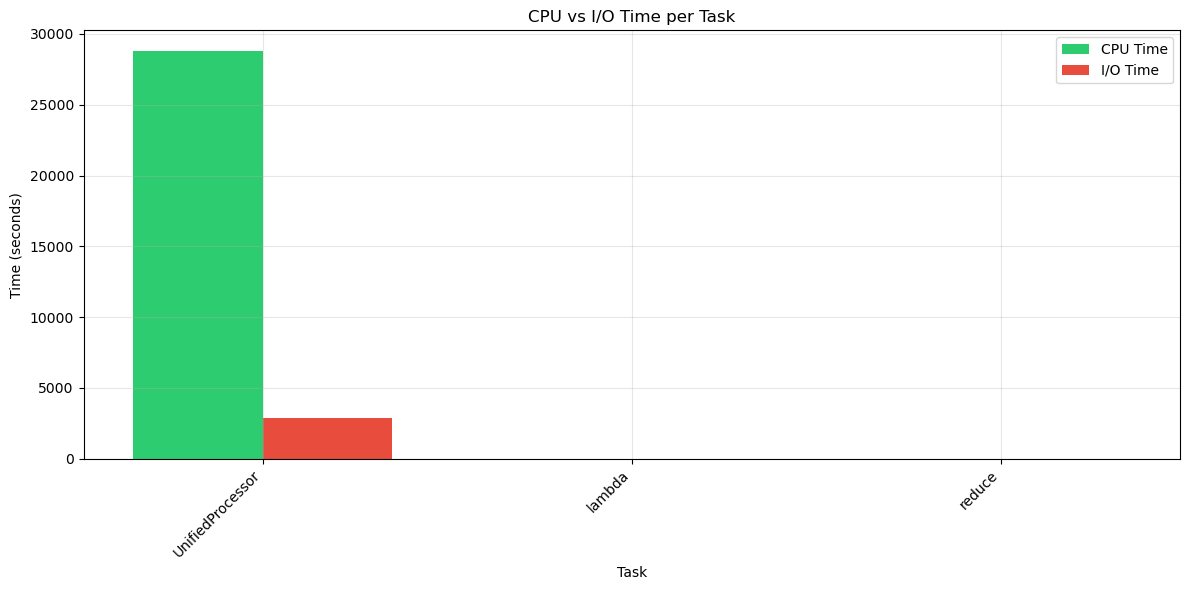

In [18]:
# ========================================================================
# CPU vs non-CPU time per task
# This shows how much time did each task spend doing cpu work vs non-cpu work
# ========================================================================
print("\n📊 Per-Task CPU vs Non-CPU Breakdown")
try:
  fig, ax = plot_per_task_cpu_io(span_metrics)
  plt.show()
except Exception as e:
  print(f"⚠️  CPU/IO plot unavailable: {e}")

#### Processor Statistics
These are plots offering insights on what is going into the processor, what the processor is doing and how complex it is.

**Processor Inputs**

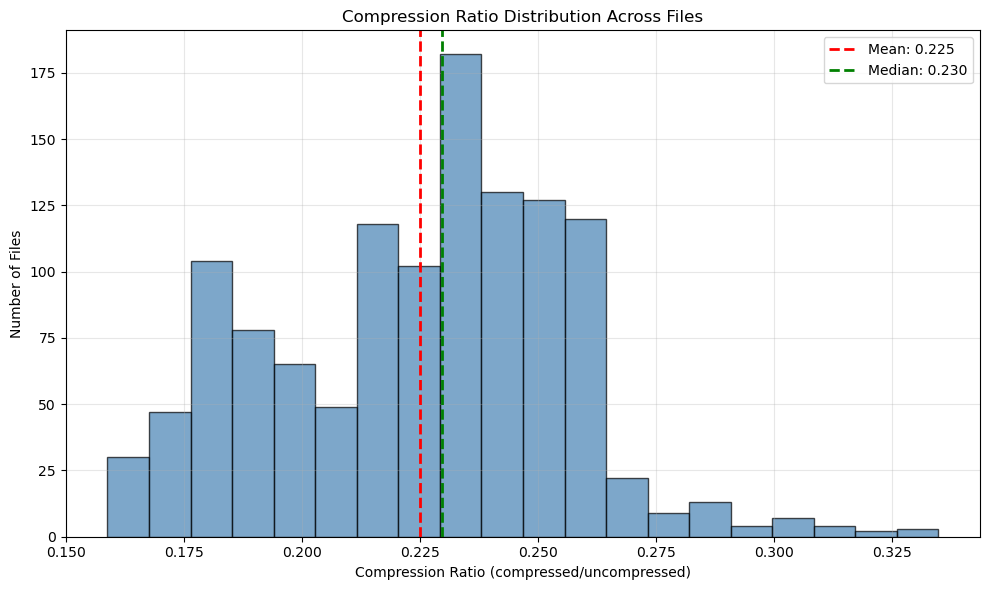

✅ Compression ratios show file compression efficiency
❌ Data access plot unavailable: No bytes read percentage data available


In [19]:
# Plot compression ratio distribution
try:
  fig, ax = plot_compression_ratio_distribution(metrics)
  plt.show()
  print("✅ Compression ratios show file compression efficiency")
except Exception as e:
  print(f"❌ Compression ratio plot unavailable: {e}")

# Plot bytes read percentage distribution
try:
  fig, ax = plot_data_access_percentage(metrics)
  plt.show()
  print("✅ Shows what % of each file's data was actually read")
except Exception as e:
  print(f"❌ Data access plot unavailable: {e}")

In [20]:
# Other useful information to complement the plots
# Branch coverage (if available)
if 'total_branches_read' in metrics:
  print(f"Branches read: {metrics['total_branches_read']}")
  print(f"Avg branches read %: {metrics.get('avg_branches_read_percent', 0):.1f}%")
  print(f"Avg bytes read %: {metrics.get('avg_bytes_read_percent', 0):.1f}%")

# Compression ratios (if available)
if 'compression_ratios' in metrics and metrics['compression_ratios']:
  import numpy as np
  ratios = metrics['compression_ratios']
  print(f"Compression ratio: {np.mean(ratios):.2f} (avg)")

# Chunk metrics (if available)
if 'chunk_metrics' in metrics and metrics['chunk_metrics']:
  print(f"Number of chunks: {len(metrics['chunk_metrics'])}")

Branches read: 24
Avg branches read %: 1.5%
Avg bytes read %: 0.0%
Compression ratio: 0.23 (avg)


**Runtime**

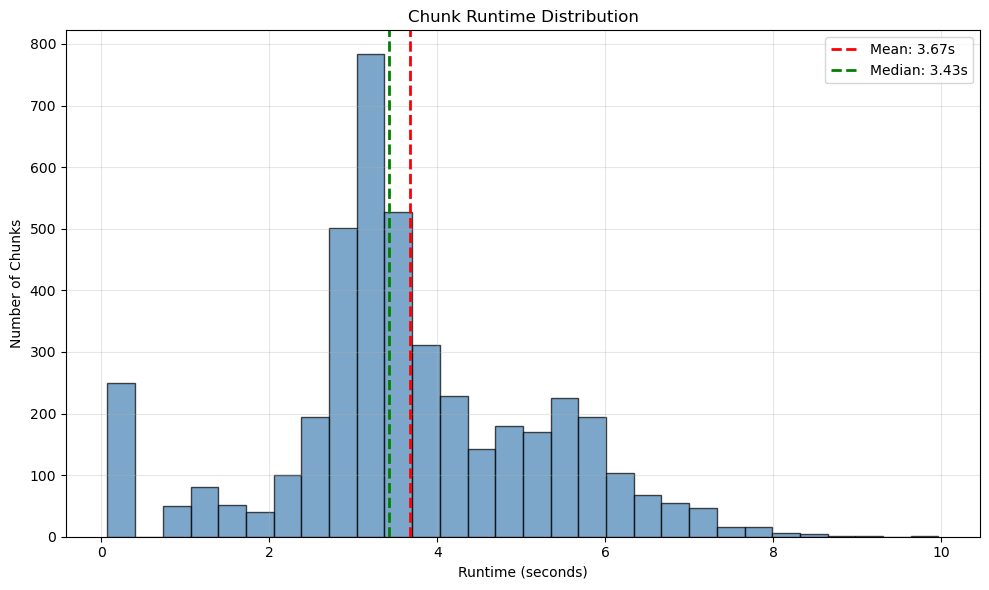

✅ Runtime distribution shows processing time variability


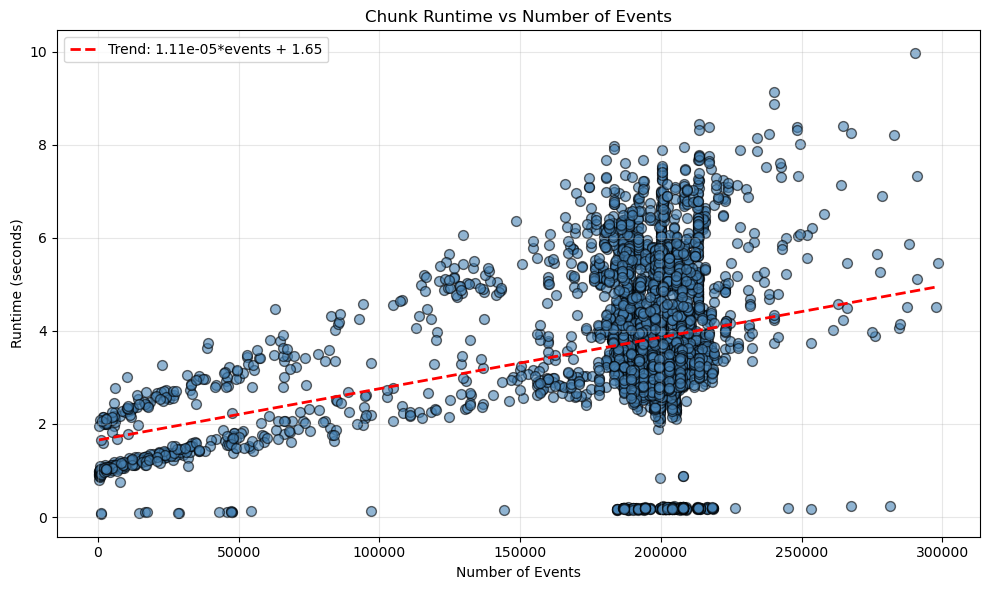

✅ Runtime vs events shows scaling behavior


In [21]:
# Plot chunk runtime distribution
try:
  fig, ax = plot_runtime_distribution(metrics.get('raw_chunk_metrics'))
  plt.show()
  print("✅ Runtime distribution shows processing time variability")
except Exception as e:
  print(f"❌ Runtime distribution unavailable: {e}")

# Plot runtime vs number of events
try:
  fig, ax = plot_runtime_vs_events(metrics.get('raw_chunk_metrics'))
  plt.show()
  print("✅ Runtime vs events shows scaling behavior")
except Exception as e:
  print(f"❌ Runtime vs events plot unavailable: {e}")

### And many more!

See https://roastcoffea.readthedocs.io/en/latest/ for more information!